In [2]:
import pandas as pd
from itertools import combinations # to create unique co-author pairs from the list of authors for each paper
from itertools import chain # to flatten the list of lists of co-author pairs efficiently
from collections import Counter # to count each co-author pair
import networkx as nx
import json
from networkx.readwrite import json_graph
import numpy as np
from scipy import stats
import ast
import netwulf

# Random Network - Part 1.1

In [5]:
#Opening the Social Science graph from Week 4 for use later:
with open("network.json", "r") as f:
    graph_data = json.load(f)

# Convert the data back into a NetworkX graph object
Graph = json_graph.node_link_graph(graph_data)

Generating the random network by finding p:

The formula for p is given by:

$$L = p \cdot \frac{N(N-1)}{2}$$

Average edge count is then:

$$k = \frac{2\cdot L}{N}$$

In [ ]:
num_nodes = Graph.number_of_nodes()
num_edges = Graph.number_of_edges()

#Solve for p using formula:
Lmax = num_nodes * (num_nodes - 1) / 2  
p = num_edges / Lmax  
print(f"Calculated probability p: {p}")

#Find k using formula
average_degree = (2 * num_edges) / num_nodes
print(f"Average degree: {average_degree}")

#Using built in renyi_graph function where each edge is chosen from p:
random_graph = nx.erdos_renyi_graph(num_nodes, p)

Calculated probability p: 0.0005212759472531752
Average degree: 7.871266803522945


In section 3.6 is denoted the "Giant Component". This is a large connected component or sub-network that is as the name suggests has a significant number of the nodes in a random network. There is a critical threshold given:

$p_c \sim \frac{1}{N}$ (3.11)

Where, this cluster will emerge for $p > p_c$

In [7]:
critical_point = 1/num_nodes
print(critical_point)
p > critical_point


6.622078008078935e-05


True

Since p is well above $p_c$, and average degree is well above 1 (3.10), the network falls into the "Supercritical Regime", as the average edge count is not quite large enough to be Connected:

In [8]:
np.log(num_nodes)

9.62251624577579

Visualizing the real and random networks:

In [ ]:
for node, data in Graph.nodes(data=True):
    country_value = data.get('country', 'none')
    data['group'] = country_value #Use built in color functionality
    
#config doesn't actually seem to do anything...
netwulf.visualize(
    Graph,
    config={
        'colorPalette': 'category10',  # Use distinct colors
        'zoom': 0.6,
        'nodeCharge': -50,
        'gravity': 0.25
    }
)#Use: Size by strength; Node size 50.

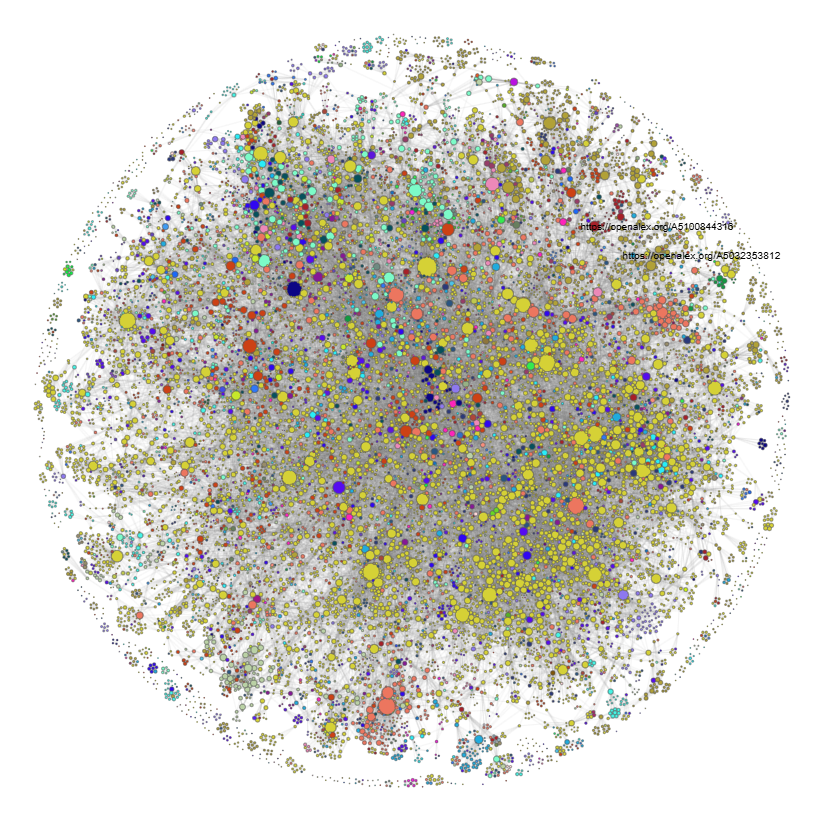

In [9]:
netwulf.visualize(random_graph) # Random graph

(None, None)

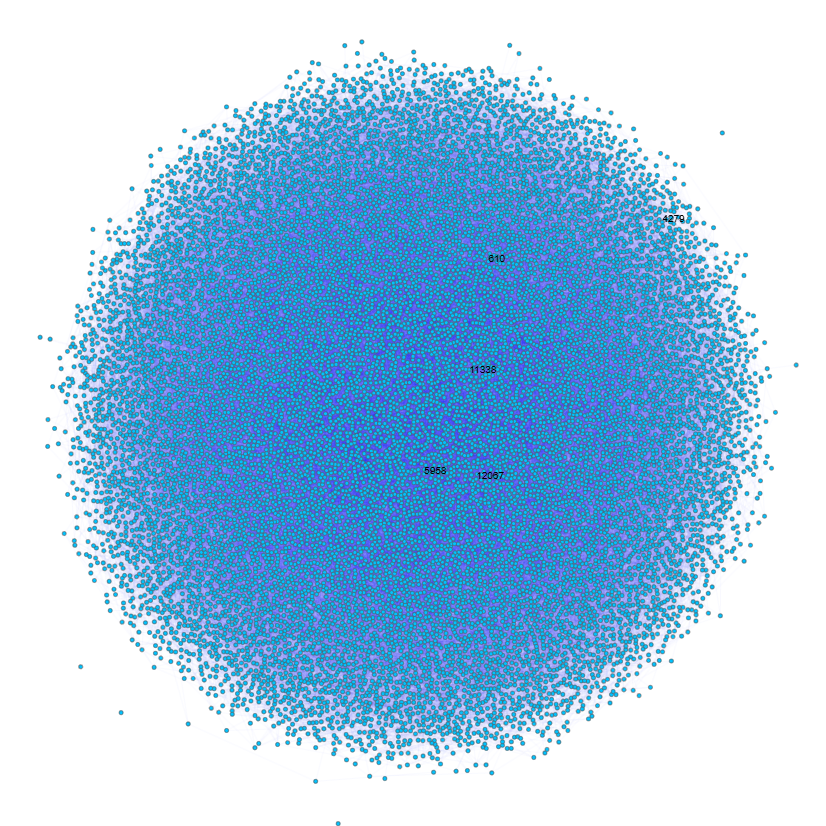

It's evident that the real network has an "inner" Giant Cluster (Component) whereas the random graph is uniform. The real network has a smaller "halo" around its periphery, these are the authors with very few co-authored papers and we can spot small clusterings where a small group of authors have collaborated together in 'isolation' 

Here, the nodes are scaled to strength so bigger nodes are authors with *many* co-authored papers, and it's evident that a handful of nodes dominate the graph making it consistent with the power-law distribution of edge counts.

Visually therefore we can spot: The large connected component, evidence of the small world property and a heavy right tailed distribution on edge-counts.

# Shortest Paths - Part 1.2

In [51]:
#list of connected components:
connected_components = list(nx.connected_components(Graph))
#Finding the biggest set, from the list:
largest_component = max(connected_components, key=len)
giant_component = Graph.subgraph(largest_component)

In [ ]:
# The algorithm here is of O^3 complexity. We've used an approximation instead
# Which can be seen below:

#avg_len = nx.average_shortest_path_length(giant_component)
#print(f"Average shortest path length for the giant component: {avg_len}")

In [36]:
#Same procedure for the random graph:
connected_components = list(nx.connected_components(random_graph))
largest_component = max(connected_components, key=len)
giant_component_rnd = random_graph.subgraph(largest_component)

In [48]:
import random
#Algortihm that approximates the shortest path lengths:
def sample_shortest_paths(graph, num_samples):
    nodes = list(graph.nodes())
    total_path_length = 0
    count = 0
    
    for _ in range(num_samples):
        node1, node2 = random.sample(nodes, 2)
        try:
            path_length = nx.shortest_path_length(graph, source=node1, target=node2)
            total_path_length += path_length
            count += 1
        except nx.NetworkXNoPath:
            continue  

    if count > 0:
        return total_path_length / count
    else:
        return float('inf') 

In [50]:
approx_average_path = sample_shortest_paths(giant_component, 10000)
print("Approximated average shortest path - SoSci LC:", approx_average_path)

approx_average_path = sample_shortest_paths(giant_component_rnd, 10000)
print("Approximated average shortest path - Rnd LC:", approx_average_path)

Approximated average shortest path - SoSci LC: 5.2187
Approximated average shortest path - Rnd LC: 4.8869


In [47]:
def average_dist_approximation(graph):
    N = graph.number_of_nodes()
    avg_degree = sum(dict(graph.degree()).values()) / N
    avg_shortest_path = np.log(N) / np.log(avg_degree)
    return avg_shortest_path

approx_shortest_path_real = average_dist_approximation(giant_component)
approx_shortest_path_rnd = average_dist_approximation(giant_component_rnd)

print(f"Approx distance in the Soc Sci Network: {approx_shortest_path_real}")
print(f"Approx distance in the Randomized Network: {approx_shortest_path_rnd}")

real_clustering = nx.average_clustering(Graph)
print(f"Global Clustering Coefficient of Real Network: {real_clustering}")

random_clustering = nx.average_clustering(random_graph)
print(f"Global Clustering Coefficient of Random Network: {random_clustering}")

Approx distance in the Soc Sci Network: 4.540601588072172
Approx distance in the Randomized Network: 4.667830998906832
Global Clustering Coefficient of Real Network: 0.6743495300569372
Global Clustering Coefficient of Random Network: 0.0005785726281990994


*Social Science Graph*

The reason why we might be interested in the giant components primarily, is because we saw in the previous exercise (not part of the assignment), the Social Scientists network exhibits a heavy right-tailed distribution such that, the vast majority of nodes in the network are either isolated, or with relatively few connections. There is therefore a range of nodes with very high edge count - hence the extreme right tail. 

In terms of focussing on the Giant Component, we therefore focus on the general real-world network structure and omit the isolated nodes. These don't contribute much to the structure of the network that constitutes most of the behavior of the nodes with very high edge count.

We've also calculated the approximate, average distance (3.19) and see that it is close to the calculated average shortest path between nodes. We can therefore say with high certainty that the network does exhibit the small-world property since, in spite of the large number of nodes <5 steps are typically needed for two nodes to reach eachother.

*The Random Graph*

We might be inclined to also believe the random network exhibits the same behavior since it also has an average distance that is close to the average observed shortest path lenght - and indeed both networks have similar figures here. 

But using the extension of the "Small world property" definition (Box 3.9) we observe that the clustering coefficient for the random network is much, much smaller.

This indicates that while the random network is also highly connected, it does not form the same type of close clustering where there is a high density of interconnected nodes within the largest component. 

Therefore the random network doesn't fit the Small worlds property.

*Unweighed Edges*

Generally we avoid using node strengths here because we are mainly interested in the physical structure of the networks, and how the random network differs from the real-world one of Social Scientists. Using unweighed edges allows us to make these comparisons directly to investigate the small-world property.
